#Automatic differentiation

Author(s): [Jukka Aho](<jukka.aho@kapsi.fi>)

https://github.com/ovainola/JuliaFEM/issues/14

Some tests considering automatic differentiation. Basic question is: *how much do we lose on computation time using automatic differentiation compared to the analytical tangent stiffness matrix*?

It is already known that evaluation of Jacobian takes $n$ function calls, where $n$ is number of unknown parameters. Analytical solution takes only one call, but the function is more cumbersome and needs more cpu time. In linear 2d quadrangle case I assume that we need 8 calls per element. We can expect that autodiffed stiffness matrix evaluation is a bit slower, but interesting question is that are these two strategies even in same decade. FENiCS uses automatic differentiation succesfully so in principle it should work.

**TODO**

- Evaluate 10000 tangent stiffness matrices analytically (nonlinear_stiffness) and 10000 stiffness matrices using automatic differentiation (Kt).
- @time it.
- Check that analytical and automatically differentiated matrices match, they should be 1:1.
- Optimize tangent stiffness matrix code for both cases

ForwardDiff is not behaving nicely (or at least I cannot debug it), so we need to try DualNumbers directly. 

In [1]:
using DualNumbers
using PyPlot

INFO: Loading help data...


## Example: solving scalar equation

Find root for $f(x) = -2 + x + x^2$. Roots are $\{-2, 1\}$.

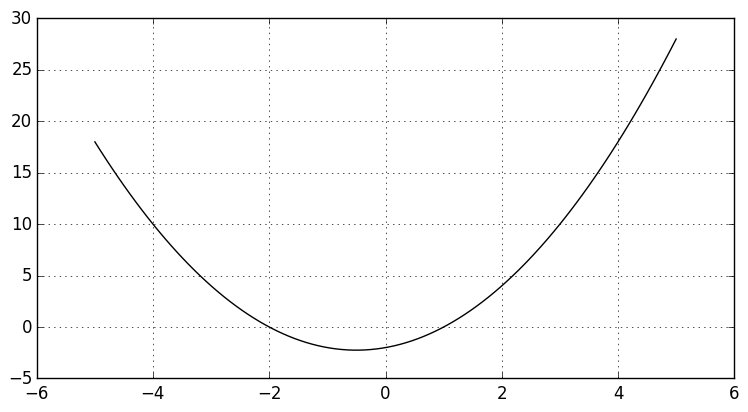

In [2]:
x = linspace(-5, 5)
f(x) = -2 + x + x.^2
plot(x, f(x), "-k")
grid()

In [3]:
x = 0
for i = 1:10
    e = f(dual(x, 1)) # here we evaluate function f using dual number
    dx = real(e)/epsilon(e) # calculate dx and perform newton iteration
    x -= dx
    println(x, " ", dx)
end

2.0 -2.0
1.2 0.8
1.011764705882353 0.18823529411764703
1.00004577706569 0.011718928816662783
1.000000000698492 4.577636719815749e-5
1.0 6.984919306363482e-10
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


Works like a charm. We get derivative and function evaluated at same time. Beautiful solution.

## Multidimensional functions

From ForwardDiff example:

In [4]:
using ForwardDiff

function f!(x, y)
    println("Evaluated")
    y[1] = x[1]^2+x[2]
    y[2] = 3*x[1]
    y[3] = x[1]^2*x[2]^3
end

# Using forwarddiff_jacobian
j = forwarddiff_jacobian(f!, Float64, fadtype=:dual, n=2, m=3)

j([2.1, 1.5])

Evaluated
Evaluated


3x2 Array{Float64,2}:
  4.2     1.0   
  3.0     0.0   
 14.175  29.7675

In [5]:
j([3.0, 4.0])

Evaluated
Evaluated


3x2 Array{Float64,2}:
   6.0    1.0
   3.0    0.0
 384.0  432.0

 That is, we need $n=2$ evaluations to get Jacobian. Each time.

# Comparisons

In [6]:
# Partial derivatives of bilinear Lagrange polynomials
dNdξ(ξ) = [[-(1-ξ[2])/4.0    -(1-ξ[1])/4.0],
           [ (1-ξ[2])/4.0    -(1+ξ[1])/4.0],
           [ (1+ξ[2])/4.0     (1+ξ[1])/4.0],
           [-(1+ξ[2])/4.0     (1-ξ[1])/4.0]]    

E = 90
ν = 0.25

μ = E/(2*(1+ν))
λ = E*ν/((1+ν)*(1-2*ν))
λ = 2*λ*μ/(λ + 2*μ)

δ = eye(2)
C = zeros(2, 2, 2, 2)
C_sym = zeros(size(C))

for i=1:2
    for j=1:2
        for k=1:2
            for l=1:2
                C[i,j,k,l] = λ*δ[i,j]*δ[k,l] + μ*(δ[i,k]*δ[j,l] + δ[i,l]*δ[j,k]) 
            end
        end
    end
end

for i=1:2
    for j=1:2
        for k=1:2
            for l=1:2
                C_sym[i,k,j,l] = 1/4*(C[i,k,j,l] + C[i,k,l,j] + C[k,i,j,l] + C[k,i,l,j])
            end
        end
    end
end

D = E/(1-ν^2)*[[1 ν 0], [ν 1 0], [0 0 (1-ν)/2]]

3x3 Array{Float64,2}:
 96.0  24.0   0.0
 24.0  96.0   0.0
  0.0   0.0  36.0

In [7]:
a = 1/sqrt(3)
ipoints = [[-a -a], [a -a], [a a], [-a a]]
iweights = [1 1 1 1]

1x4 Array{Int64,2}:
 1  1  1  1

In [8]:
function nonlinear_stiffness(X, u)
    n_integration_points = length(iweights)
    n_problem_dimension = 2
    n_solution_dimension = 2
    n_shape_functions = 4
    n_dofs = n_solution_dimension*n_shape_functions
    K2_L = zeros((n_dofs, n_dofs))
    K2_NL = zeros((n_dofs, n_dofs))
    T = zeros((n_solution_dimension, n_shape_functions))
    B_L = zeros(3, 8)
    B_NL = zeros(4, 8)

    for m = 1:n_integration_points
        ξ = ipoints[m, :]
        w = iweights[m]

        Jᵀ = X*dNdξ(ξ)
        ∇N = inv(Jᵀ)*dNdξ(ξ)'
        ∇u = u*∇N'
        F = I + ∇u  # Deformation gradient

        detJ = det(Jᵀ)
        #detF = det(F)
        E = 1/2*(∇u + ∇u' + ∇u'*∇u) # Green-Lagrange strain tensor
        P = λ*trace(E)*eye(2) + 2*μ*E # PK2 stress tensor
        S = F*P

        B_L[:,:] = 0
        for i = 0:3
            B_L[1, i*2+1] = F[1, 1]*∇N[1, i+1]
            B_L[1, i*2+2] = F[2, 1]*∇N[1, i+1]
            B_L[2, i*2+1] = F[1, 2]*∇N[2, i+1]
            B_L[2, i*2+2] = F[2, 2]*∇N[2, i+1]
            B_L[3, i*2+1] = F[1, 1]*∇N[2, i+1] + F[1, 2]*∇N[1, i+1]
            B_L[3, i*2+2] = F[2, 1]*∇N[2, i+1] + F[2, 2]*∇N[1, i+1]
        end
        K2_L += w*B_L'*D*B_L*detJ

        τ = zeros(4, 4)
        τ[1:2,1:2] = S
        τ[3:4,3:4] = S
        B_NL[:,:] = 0.0
        for i=0:3
            B_NL[1, 2*i+1] = ∇N[1, i+1]
            B_NL[2, 2*i+1] = ∇N[2, i+1]
            B_NL[3, 2*i+2] = ∇N[1, i+1]
            B_NL[4, 2*i+2] = ∇N[2, i+1]
        end
        K2_NL += w*B_NL'*τ*B_NL*detJ

        # Nodal forces
        T += w*S*∇N*detJ

    end

    return T', K2_L+K2_NL
end

nonlinear_stiffness (generic function with 1 method)

In [9]:
X = [0 0; 1 0; 1 1; 0 1]'
u = [0 0; 0 0; 1 0; 0 0]'

2x4 Array{Int64,2}:
 0  0  1  0
 0  0  0  0

In [10]:
@time nonlinear_stiffness(X, u)

elapsed time: 1.159613267 seconds (79896004 bytes allocated, 4.41% gc time)


(
4x2 Array{Float64,2}:
 -60.6667   -24.0
  -1.33333   -8.0
 133.333     35.0
 -71.3333    -3.0,

8x8 Array{Float64,2}:
  136.333    34.0      -29.3333   -2.0      …  -34.0       23.0      2.0   
   34.0      81.6667     6.0       3.33333     -71.6667    -7.0    -13.3333
  -42.3333    6.0       83.3333   10.0         -28.0      -45.0     12.0   
   -2.0      -9.66667   10.0      52.6667      -11.3333    11.0    -31.6667
 -127.333   -33.0      -20.6667  -19.0          55.0     -153.333   -3.0   
  -34.0     -69.0      -28.0     -36.0      …  162.667      7.0    -57.6667
   33.3333   -7.0      -33.3333   11.0           7.0      175.333  -11.0   
    2.0      -3.0       12.0     -20.0         -79.6667   -11.0    102.667 )

In [11]:
function gauss2d(J, Wint)
    a = 1/sqrt(3)
    ipoints = [[-a -a], [a -a], [a a], [-a a]]
    iweights = [1 1 1 1]
    Wint[:,:] = 0

    for m = 1:length(iweights)
        w = iweights[m]
        ξ = ipoints[m, :]
        Wint[:,:] += w*J(ξ)
    end
end

function calculate_internal_energy!(X, u, Wint, dNdξ, λ, μ, dim=2)
    u = reshape(u, 2, 4)
    X = reshape(X, 2, 4)
    Wint = reshape(Wint, 2, 4)
    I = eye(dim)
    
    function J(ξ)
        Jᵀ = X*dNdξ(ξ)
        ∇N = inv(Jᵀ)*dNdξ(ξ)'
        ∇u = u*∇N'
        F = I + ∇u  # Deformation gradient
        E = 1/2*(∇u' + ∇u + ∇u'*∇u)  # Green-Lagrange strain tensor
        P = λ*trace(E)*I + 2*μ*E  # PK1 stress tensor
        S = F*P  # PK2 stress tensor
        return S*∇N*det(Jᵀ)
    end

    gauss2d(J, Wint)
    u = reshape(u, 8)
    X = reshape(X, 8)
    Wint = reshape(Wint, 8)

end

calculate_internal_energy! (generic function with 2 methods)

In [12]:
function Winte!(u, Wint)
    calculate_internal_energy!(X, u, Wint, dNdξ, λ, μ)
end
Wint = zeros(8)
Winte!(reshape(u, 8), Wint)
Wint

8-element Array{Float64,1}:
 -60.6667 
 -24.0    
  -1.33333
  -8.0    
 133.333  
  35.0    
 -71.3333 
  -3.0    

In [13]:
using ForwardDiff
Kt = forwarddiff_jacobian!(Winte!, Float64, fadtype=:dual, n=8, m=8)

g! (generic function with 1 method)

In [14]:
J = zeros(8, 8)
Kt(reshape(u, 8), J)
Kt

LoadError: `dual_fad` has no method matching dual_fad(::Function, ::Array{Int64,1}, ::Array{Float64,2}, ::Array{Dual{Float64},1}, ::Array{Dual{Float64},1})
while loading In[14], in expression starting on line 2

This ForwardDiff package is just not working as expected. We have well defined function but for some reason it's just not working. Bad code.

In [15]:
function calc_1()
    for i=1:10000
       K, T = nonlinear_stiffness(X, u)
    end
end
@time calc_1()

elapsed time: 1.198824455 seconds (532828332 bytes allocated, 27.60% gc time)
